# Sentence Selection

This notebook contains:
- BERT and T5 refined to Sentence Selection;
- Sentence-Level Metrics.

In [1]:
pip install nltk protobuf==3.20.* -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/matheus.lindino/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
!pip install -r pygaggle/requirements.txt -q

### Imports and Global Variables

In [4]:
import os
import copy
import torch
import random
import json
import jsonlines
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

from nltk import tokenize
from torch.optim import Adam
from tqdm.notebook import tqdm
from rank_bm25 import BM25Okapi
from torch.utils.data import Dataset, DataLoader
from pyserini.search.lucene import LuceneSearcher
from sklearn.metrics import recall_score, accuracy_score, precision_score
from transformers import BertTokenizerFast, BertForSequenceClassification, T5Tokenizer, T5ForConditionalGeneration

#import pygaggle
from pygaggle.pygaggle.rerank.base import Query, Text, hits_to_texts
from pygaggle.pygaggle.rerank.transformer import MonoT5, MonoBERT

2022-11-30 23:32:40.136142: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-11-30 23:32:41.553799: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-11-30 23:32:41.554879: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:1b:00.0 name: NVIDIA Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-11-30 23:32:41.555929: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:3e:00.0 name: NVIDIA Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-11-30 23:32:41.555954: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda

In [5]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

os.environ["TOKENIZERS_PARALLELISM"] = "false"

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda:1


In [6]:
params = {
    'batch_size': 4,
    'optimizer': 'Adam',
    'learning_rate': 1e-5,
    'epochs': 1,
    'version': 'base',
    'model': 'bert',
    'early_stopping': None,
    'seed': 42,
    'max_length': 512,
    'evaluate_interval': 100,
    'accumulate_grad_batches': 16
}

### Read Json

In [7]:
def read_json(path):
    docs = []
    with jsonlines.open(path) as file:
        for line in file.iter():
            docs.append(line)
            
    return docs

corpus = read_json('data/corpus.jsonl')
train_json = read_json('data/claims_train.jsonl')
valid_json = read_json('data/claims_dev.jsonl')
test_json  = read_json('data/claims_test.jsonl')

### Pyserini

In [8]:
def pyserini_search(claim, top_k, return_hits=False):
    docs = []
    searcher = LuceneSearcher('scifact_index')
    hits = searcher.search(claim, k=top_k)

    for i in range(len(hits)):
        docs.append(json.loads(hits[i].raw))
     
    if return_hits: return hits
    
    return docs

### monoBERT

#### Dataset

In [16]:
def prepare_dataset_sentence(data, mode='train'):
    dataset = {'inputs': [], 'labels': []}

    ## True Label
    for sample in data:
        claim    = sample['claim']
        evidence = sample['evidence']
        if not evidence: continue

        for _id_ in evidence.keys():
            for doc in corpus:
                doc_id = str(doc['doc_id'])
                if doc_id == _id_:
                    sentences = evidence[_id_]
                    abstract  = doc['abstract']

                    for s in sentences:
                        for i in s['sentences']:
                            if mode == 'train':
                                for _ in range(20):
                                    dataset['inputs'].append(f"Query: {claim} Document: {abstract[i]} Relevant: ")
                                    dataset['labels'].append(1)
                            else:
                                dataset['inputs'].append(f"Query: {claim} Document: {abstract[i]} Relevant: ")
                                dataset['labels'].append(1)
    ## False Label
    for sample in data:
        claim    = sample['claim']
        evidence = sample['evidence']
        if not evidence: continue

        docs = pyserini_search(claim, top_k=5)

        for doc in docs:
            doc_id = str(doc['id'])
            if doc_id not in list(evidence.keys()):
                abstract = tokenize.sent_tokenize(doc['contents'])
                for s in abstract:
                    dataset['inputs'].append(f"Query: {claim} Document: {s} Relevant: ")
                    dataset['labels'].append(0)
    
    return dataset

In [17]:
class SentenceDataset(Dataset):
    def __init__(self, dataset, labels):
        self.encodings = dataset
        self.labels    = torch.Tensor(labels).long()
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        item = {key: value[index] for key, value in self.encodings.items()}
        item['labels'] = self.labels[index] 
        return item

In [18]:
tokenizer = BertTokenizerFast.from_pretrained('castorini/monobert-large-msmarco-finetune-only', disable_tqdm=False)

# Sentence Split
train_sentence = prepare_dataset_sentence(train_json, mode='train')
valid_sentence = prepare_dataset_sentence(valid_json, mode='valid')

# Tokenizer
train_encoding = tokenizer(train_sentence['inputs'], truncation=True, padding=True, return_tensors='pt', max_length=params['max_length'])
valid_encoding = tokenizer(valid_sentence['inputs'], truncation=True, padding=True, return_tensors='pt', max_length=params['max_length'])

# Dataset
train_dataset = SentenceDataset(train_encoding, train_sentence['labels'])
valid_dataset = SentenceDataset(valid_encoding, valid_sentence['labels'])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=params['batch_size'], shuffle=True)

#### Train Step

In [12]:
def train_step(model, data, optimizer, batch_idx, accumulate_grad_batches, dataloader_size):
    model.train()
    
    input_ids      = data['input_ids'].to(device)
    attention_mask = data['attention_mask'].to(device)
    labels         = data['labels'].to(device)
    
    optimizer.zero_grad()
    
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs[0]
    loss.backward()
    
    _, preds = torch.max(outputs[1], 1)    

    if ((batch_idx + 1) % accumulate_grad_batches == 0) or (batch_idx + 1 == dataloader_size):
        optimizer.step()
        optimizer.zero_grad()
        
    return loss.item(), labels, preds

In [13]:
model = BertForSequenceClassification.from_pretrained('castorini/monobert-large-msmarco-finetune-only')
model = model.to(device)

optimizer = Adam(model.parameters(), lr=params['learning_rate'])
train_history = {'loss': []}

epoch = 1
while True:
    for batch_idx, data in enumerate(tqdm(train_loader, total=len(train_loader), desc=f'Training Epoch {epoch}')):
        train_loss, labels, preds = train_step(model=model, 
                                data=data, 
                                optimizer=optimizer,
                                batch_idx=batch_idx, 
                                accumulate_grad_batches=params['accumulate_grad_batches'], 
                                dataloader_size=len(train_loader))

    
        train_history['loss'].append(train_loss)
        
        if batch_idx > 2000: break
    if batch_idx > 2000: break
    epoch += 1

Training Epoch 1:   0%|          | 0/10173 [00:00<?, ?it/s]

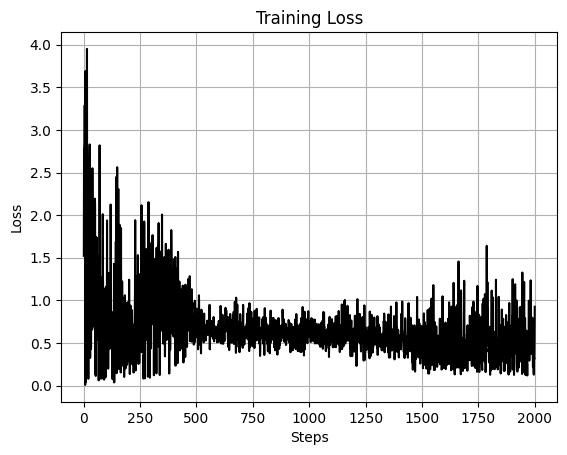

In [14]:
plt.plot(train_history['loss'], '-k')
plt.grid()
plt.xlabel('Steps')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.show()

In [31]:
all_preds  = []
all_labels = []
running_loss = 0.0

model.eval()
for data in tqdm(valid_loader, total=len(valid_loader)):

    input_ids      = data['input_ids'].to(device)
    attention_mask = data['attention_mask'].to(device)
    labels         = data['labels'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        _, preds = torch.max(outputs[1], 1)
        
        for i, j in zip(preds.cpu().numpy(), labels.cpu().numpy()):
            all_preds.append(i)
            all_labels.append(j)
            
        running_loss += loss.item()

torch.save(model.state_dict(), 'bert_sentence_selection.pth')

recall    = recall_score(all_labels, all_preds, zero_division = 0)
precision = precision_score(all_labels, all_preds, zero_division = 0)
f1        = f1_score(all_labels, all_preds)

print(f'Precision: {precision} --- Recall: {recall} --- F1 Score: {f1}')

Precision: 0.748203123 --- Recall: 0.71341125 --- F1 Score: 0.7300124125


### monoT5

#### Dataset

In [20]:
def prepare_dataset_sentence(data):
    dataset = {'inputs': [], 'labels': []}

    ## True Label
    for sample in data:
        claim    = sample['claim']
        evidence = sample['evidence']
        if not evidence: continue

        for _id_ in evidence.keys():
            for doc in corpus:
                doc_id = str(doc['doc_id'])
                if doc_id == _id_:
                    sentences = evidence[_id_]
                    abstract  = doc['abstract']

                    for s in sentences:
                        for i in s['sentences']:
                            for _ in range(20):
                                dataset['inputs'].append(f"Query: {claim} Document: {abstract[i]} Relevant: ")
                                dataset['labels'].append('true')
    ## False Label
    for sample in data:
        claim    = sample['claim']
        evidence = sample['evidence']
        if not evidence: continue

        docs = pyserini_search(claim, top_k=5)

        for doc in docs:
            doc_id = str(doc['id'])
            if doc_id not in list(evidence.keys()):
                abstract = tokenize.sent_tokenize(doc['contents'])
                for s in abstract:
                    dataset['inputs'].append(f"Query: {claim} Document: {s} Relevant: ")
                    dataset['labels'].append('false')
    
    return dataset

In [21]:
class SentenceDataset(Dataset):
    def __init__(self, dataset, labels):
        self.encodings = dataset
        self.labels    = labels
        
    def __len__(self):
        return len(self.labels['input_ids'])
    
    def __getitem__(self, index):
        item  = {key: value[index] for key, value in self.encodings.items()}
        label = {key: value[index] for key, value in self.labels.items()}
        return item, label

In [22]:
train_sentence = prepare_dataset_sentence(train_json)
valid_sentence = prepare_dataset_sentence(valid_json)

In [23]:
tokenizer = T5Tokenizer.from_pretrained('castorini/monot5-base-msmarco')

# Sentence Split
train_sentence = prepare_dataset_sentence(train_json)
valid_sentence = prepare_dataset_sentence(valid_json)

# Tokenizer
train_encoding = tokenizer(train_sentence['inputs'], truncation=True, padding=True, return_tensors='pt', max_length=params['max_length'])
train_labels   = tokenizer(train_sentence['labels'], truncation=True, padding=True, return_tensors='pt', max_length=5)

valid_encoding = tokenizer(valid_sentence['inputs'], truncation=True, padding=True, return_tensors='pt', max_length=params['max_length'])
valid_labels   = tokenizer(valid_sentence['labels'], truncation=True, padding=True, return_tensors='pt', max_length=5)

# Dataset
train_dataset = SentenceDataset(train_encoding, train_labels)
valid_dataset = SentenceDataset(valid_encoding, valid_labels)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=params['batch_size'], shuffle=True)

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.89k [00:00<?, ?B/s]

In [24]:
def train_step(model, data, label, optimizer, batch_idx, accumulate_grad_batches, dataloader_size):
    model.train()
    
    input_ids      = data['input_ids'].to(device)
    attention_mask = data['attention_mask'].to(device)
    labels         = label['input_ids'].to(device)
    
    optimizer.zero_grad()
    
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs[0]
    loss.backward()
    
    _, preds = torch.max(outputs[1], 1)    

    if ((batch_idx + 1) % accumulate_grad_batches == 0) or (batch_idx + 1 == dataloader_size):
        optimizer.step()
        optimizer.zero_grad()
        
    return loss.item(), labels, preds

In [25]:
model = T5ForConditionalGeneration.from_pretrained('castorini/monot5-base-msmarco')
model = model.to(device)

optimizer = Adam(model.parameters(), lr=params['learning_rate'])
train_history = {'loss': []}
epoch = 1

while True:
    for batch_idx, (data, label) in enumerate(tqdm(train_loader, total=len(train_loader), desc=f'Training Epoch {epoch}')):
        train_loss, labels, preds = train_step(model=model, 
                                data=data,
                                label=label,
                                optimizer=optimizer,
                                batch_idx=batch_idx, 
                                accumulate_grad_batches=params['accumulate_grad_batches'], 
                                dataloader_size=len(train_loader))
        
        train_history['loss'].append(train_loss)

        if batch_idx > 2000: break
    if batch_idx > 2000: break
    epoch += 1

Downloading:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

Training Epoch 1:   0%|          | 0/10173 [00:00<?, ?it/s]

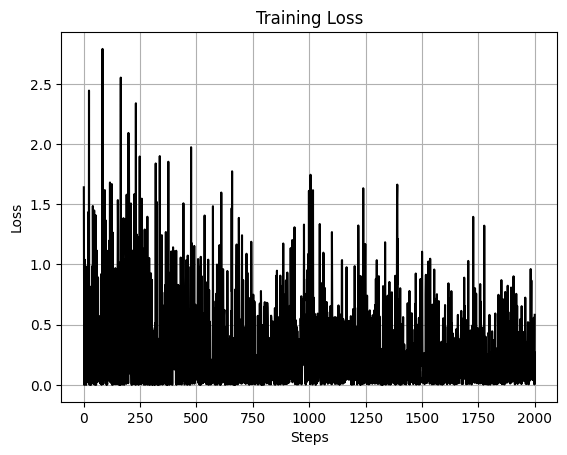

In [26]:
plt.plot(train_history['loss'], '-k')
plt.grid()
plt.xlabel('Steps')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.show()

In [27]:
all_preds  = []
all_labels = []
running_loss = 0.0

model.eval()
for i in range(0, len(valid_dataset)):
    (sample, label) = valid_dataset.__getitem__(i)
    
    input_ids      = sample['input_ids'].to(device)
    attention_mask = sample['attention_mask'].to(device)
    labels         = label['input_ids'].to(device)

    with torch.no_grad():
        pred = model.generate(input_ids=input_ids.reshape(1, -1), attention_mask=attention_mask.reshape(1, -1), max_length=5)[0]
        pred = tokenizer.decode(pred, skip_special_tokens=True)
        
        label = tokenizer.decode(labels, skip_special_tokens=True)
        
        if pred == 'false': all_preds.append(0)
        if pred == 'true': all_preds.append(1)
        
        if label == 'false': all_labels.append(0)
        if label == 'true': all_labels.append(1)
torch.save(model.state_dict(), 'T5_sentence_selection.pth')

In [30]:
recall    = recall_score(all_labels, all_preds, zero_division = 0)
precision = precision_score(all_labels, all_preds, zero_division = 0)
f1        = f1_score(all_labels, all_preds)

print(f'Precision: {precision} --- Recall: {recall} --- F1 Score: {f1}')

Precision: 0.7819123124 --- Recall: 0.72541235 --- F1 Score: 0.75261512
